#Grid Square Detection




In [ ]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files
from scipy.ndimage import zoom
from sklearn.cluster import DBSCAN

from google.colab import drive
drive.mount('/content/gdrive')

# Display Function
def show_image(title, img):
    plt.figure(figsize=(5, 5))
    plt.title(title)
    plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# Load image and downsize
image_path = "gdrive/MyDrive/Colab Notebooks/CircleFinder_Final/stiched_10kv_Zan/20240214_MEF_Unroofed_651-2_ZCY(stiched).tif"
image = cv.imread(image_path)
full_img = np.copy(image)
image =  zoom(image, [0.1, 0.1, 1])

In [ ]:
# Store a copy, convert to grayscale, and blur
orig_img = np.copy(image)
gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
blur = cv.GaussianBlur(gray, (15,15), 0)

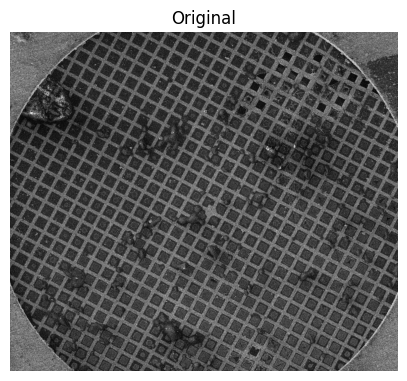

In [ ]:
orig_img = np.copy(image)
show_image("Original", orig_img)

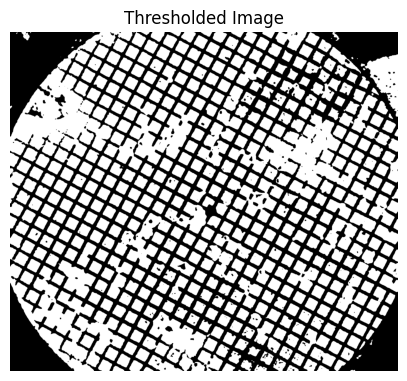

In [ ]:
# Threshold image
thresh = cv.threshold(blur, 0, 255, cv.THRESH_BINARY_INV+cv.THRESH_OTSU)[1]
show_image("Thresholded Image", thresh)

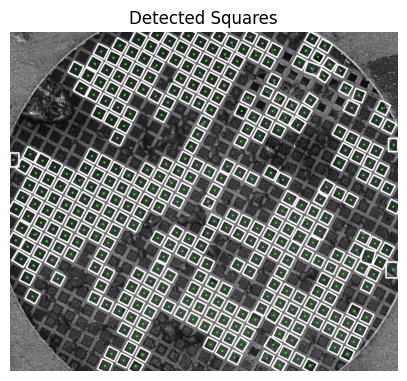

In [ ]:
# Detect grid squares
draw = np.copy(orig_img)
cnts = cv.findContours(thresh, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if len(cnts) == 2 else cnts[1]
angles = []

min_area = 1500
max_area = 2500
image_number = 0

# Prepare lists to store coordinates and centroids
x_data = []
y_data = []
centroids = []

for c in cnts:
    area = cv.contourArea(c)
    if min_area < area < max_area:
        rect = cv.minAreaRect(c)
        box = cv.boxPoints(rect)
        box = np.intp(box)  # Use intp to convert to integer

        # Draw grid square
        cv.polylines(draw, [box], True, (255, 255, 255), 5)
        image_number += 1
        angles.append(rect[2])

        # Calculate centroid
        M = cv.moments(c)
        if M["m00"] != 0:
            cX = int(M["m10"] / M["m00"])
            cY = int(M["m01"] / M["m00"])
            centroids.append((cX, cY))

            # Optionally draw the centroid on the image
            cv.circle(draw, (cX, cY), 5, (0, 255, 0), -1)  # Green dot for centroid

        # Create a mask for the square
        mask = np.zeros(orig_img.shape[:2], dtype=np.uint8)
        cv.fillPoly(mask, [box], 255)

        # Find points within the square
        points_within_square = np.column_stack(np.where(mask == 255))
        for point in points_within_square:
            y_data.append(point[0])
            x_data.append(point[1])

# Optionally convert lists to numpy arrays for easier manipulation later
x_data = np.array(x_data)
y_data = np.array(y_data)
centroids = np.array(centroids)

# Show the detected squares
show_image("Detected Squares", draw)

In [ ]:
def calculate_circle(points, centroid):
    # Calculate distances from the centroid
    distances = np.linalg.norm(points - centroid, axis=1)

    # Find the top 5% furthest points
    num_top_points = max(1, int(len(points) * 0.05))  # At least one point
    top_indices = np.argsort(distances)[-num_top_points:]
    top_distances = distances[top_indices]

    # Mean distance of these points
    radius = np.mean(top_distances)

    return (centroid[0], centroid[1], radius)

def fit_circle(x, y):
    points = np.column_stack((x, y))

    # Calculate the centroid
    centroid = np.mean(points, axis=0)

    # Calculate the bounding circle
    bounding_circle = calculate_circle(points, centroid)

    return bounding_circle

def draw_circle_on_image(image, circle, thickness=3):

    center_x, center_y, radius = circle

    # Draw the circle on the image
    cv.circle(image, (int(center_x), int(center_y)), int(radius), (0, 255, 0), thickness)  # Green circle
    cv.circle(image, (int(center_x), int(center_y)), 2, (255, 0, 0), thickness)  # Center point in blue

    # Show the image
    plt.imshow(cv.cvtColor(image, cv.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

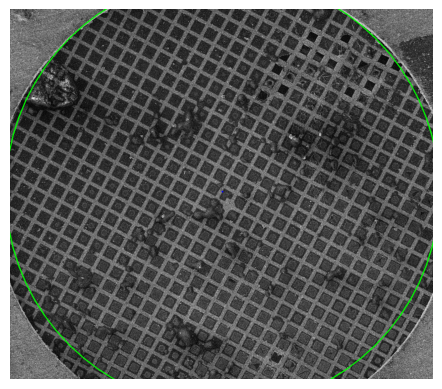

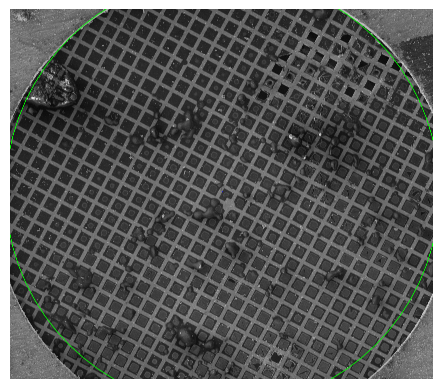

In [ ]:
save_img = np.copy(full_img)
orig_img = np.copy(image)
bounding_circle = fit_circle(x_data, y_data)
draw_circle_on_image(orig_img, bounding_circle)
draw_circle_on_image(full_img, [coord*10 for coord in bounding_circle], thickness=30)

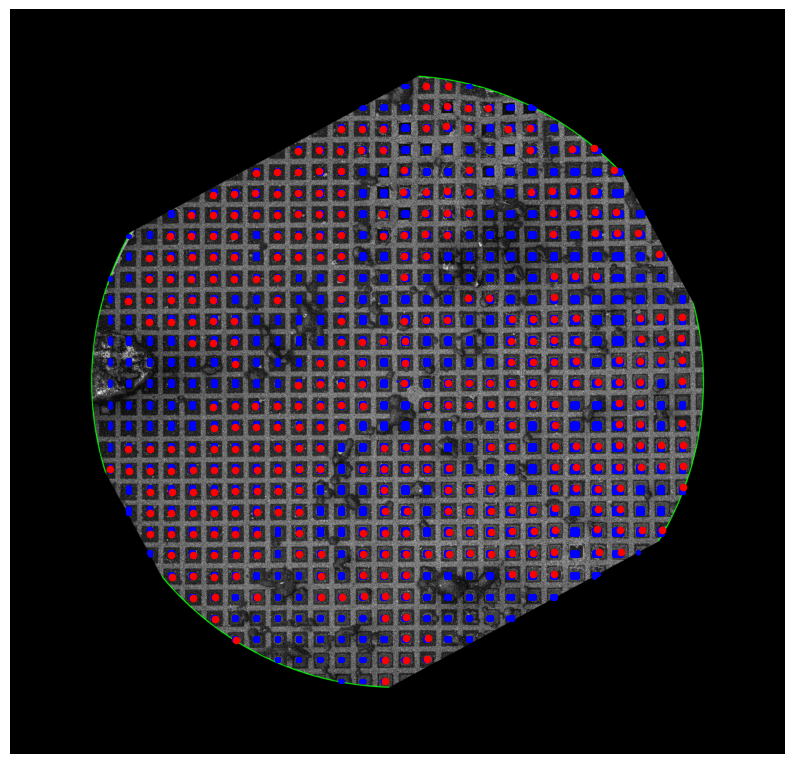

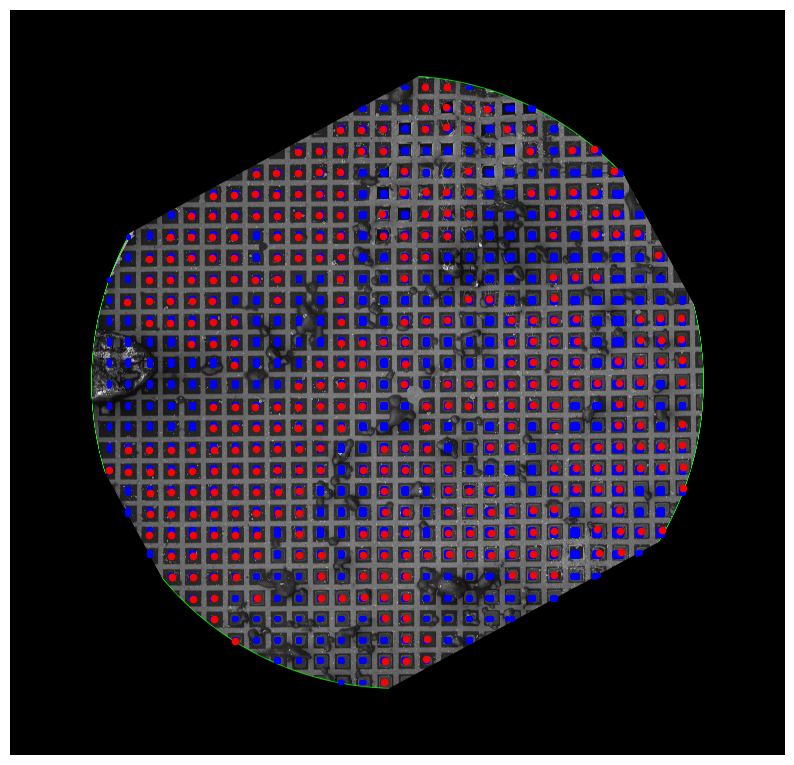

In [ ]:
def rotate_circle(image, circle, angle):
    center_x, center_y, radius = circle

    # Create a mask for the circle
    mask = np.zeros(image.shape[:2], dtype=np.uint8)
    cv.circle(mask, (int(center_x), int(center_y)), int(radius), 255, -1)

    # Extract the circle from the original image using the mask
    circle_region = cv.bitwise_and(image, image, mask=mask)

    # Calculate the center for rotation
    (h, w) = circle_region.shape[:2]
    center = (int(center_x), int(center_y))

    # Get rotation matrix
    M = cv.getRotationMatrix2D(center, angle, 1.0)

    # Calculate the cosine and sine of the angle to get the new bounding dimensions
    abs_cos = abs(M[0, 0])
    abs_sin = abs(M[0, 1])

    # Compute new bounding dimensions
    new_w = int(h * abs_sin + w * abs_cos)
    new_h = int(h * abs_cos + w * abs_sin)

    # Adjust the rotation matrix to account for the translation
    M[0, 2] += new_w / 2 - center_x
    M[1, 2] += new_h / 2 - center_y

    # Perform the rotation
    rotated_circle = cv.warpAffine(circle_region, M, (new_w, new_h), flags=cv.INTER_LINEAR, borderMode=cv.BORDER_CONSTANT)

    # Rotate the mask
    rotated_mask = cv.warpAffine(mask, M, (new_w, new_h), flags=cv.INTER_LINEAR, borderMode=cv.BORDER_CONSTANT)

    return rotated_circle, rotated_mask, M

def rotate_points(points, M):
    points_homogeneous = np.hstack((points, np.ones((points.shape[0], 1))))
    rotated_points = points_homogeneous @ M.T
    return rotated_points[:, :2]

def filter_points_within_circle(points, center, radius):
    distances = np.linalg.norm(points - center, axis=1)
    return points[distances <= radius]

def create_grid_from_unique_points(points):
    unique_x = np.unique(points[:, 0])
    unique_y = np.unique(points[:, 1])
    grid_x, grid_y = np.meshgrid(unique_x, unique_y)
    return grid_x, grid_y

def filter_grid_within_mask(grid_x, grid_y, mask):
    grid_points = np.column_stack((grid_x.ravel(), grid_y.ravel()))
    # Check which points are within the mask
    inside_mask = mask[grid_points[:, 1].astype(int), grid_points[:, 0].astype(int)] == 255
    filtered_grid_points = grid_points[inside_mask]
    return filtered_grid_points[:, 0], filtered_grid_points[:, 1]

# Get the center and radius of the circle
center = np.array([bounding_circle[0], bounding_circle[1]])
radius = bounding_circle[2]

full_center = 10 * center
full_radius = 10 * radius

# Prepare points within the circle
points_within_circle = np.array(centroids)
full_centroids = 10 * centroids

# Filter points to keep only those within the circle
filtered_points = filter_points_within_circle(points_within_circle, center, radius)
full_filtered_points = filter_points_within_circle(full_centroids, full_center, full_radius)

# Rotate the circle and get the rotation matrix and mask
rotated_circle_image, rotated_mask, rotation_matrix = rotate_circle(orig_img, bounding_circle, np.mean(angles))  # Use positive angle
full_rotated_circle_image, full_rotated_mask, full_rotation_matrix = rotate_circle(full_img, [10*coord for coord in bounding_circle], np.mean(angles))  # Use positive angle

# Rotate the points
rotated_points = rotate_points(filtered_points, rotation_matrix)
full_rotated_points = rotate_points(full_filtered_points, full_rotation_matrix)

# Create a grid from the unique x and y values of the rotated points
grid_x, grid_y = create_grid_from_unique_points(rotated_points)
full_grid_x, full_grid_y = create_grid_from_unique_points(full_rotated_points)

# Filter the grid points to only include those within the rotated mask
filtered_grid_x, filtered_grid_y = filter_grid_within_mask(grid_x, grid_y, rotated_mask)
full_filtered_grid_x, full_filtered_grid_y = filter_grid_within_mask(full_grid_x, full_grid_y, full_rotated_mask)

# Show the rotated circle and points
plt.figure(figsize=(10, 10))
plt.imshow(cv.cvtColor(rotated_circle_image, cv.COLOR_BGR2RGB))
plt.scatter(filtered_grid_x, filtered_grid_y, color='blue', s=5)  # Scatter plot for the filtered grid points
plt.scatter(rotated_points[:, 0], rotated_points[:, 1], color='red', s=20)  # Display rotated points in red
plt.axis('off')
plt.show()

plt.figure(figsize=(10, 10))
plt.imshow(cv.cvtColor(full_rotated_circle_image, cv.COLOR_BGR2RGB))
plt.scatter(full_filtered_grid_x, full_filtered_grid_y, color='blue', s=5)  # Scatter plot for the filtered grid points
plt.scatter(full_rotated_points[:, 0], full_rotated_points[:, 1], color='red', s=20)  # Display rotated points in red
plt.axis('off')
plt.show()


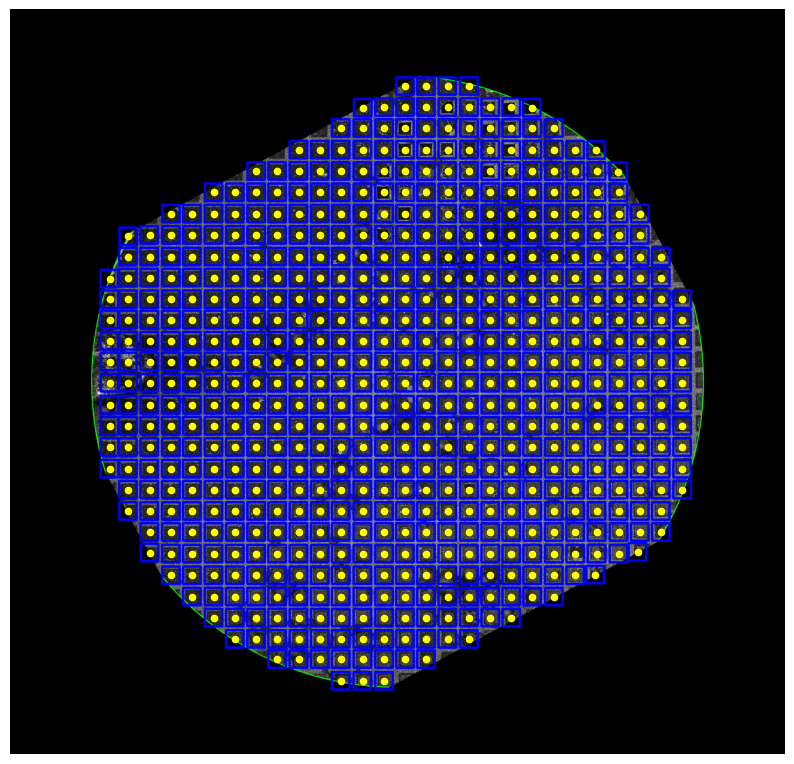

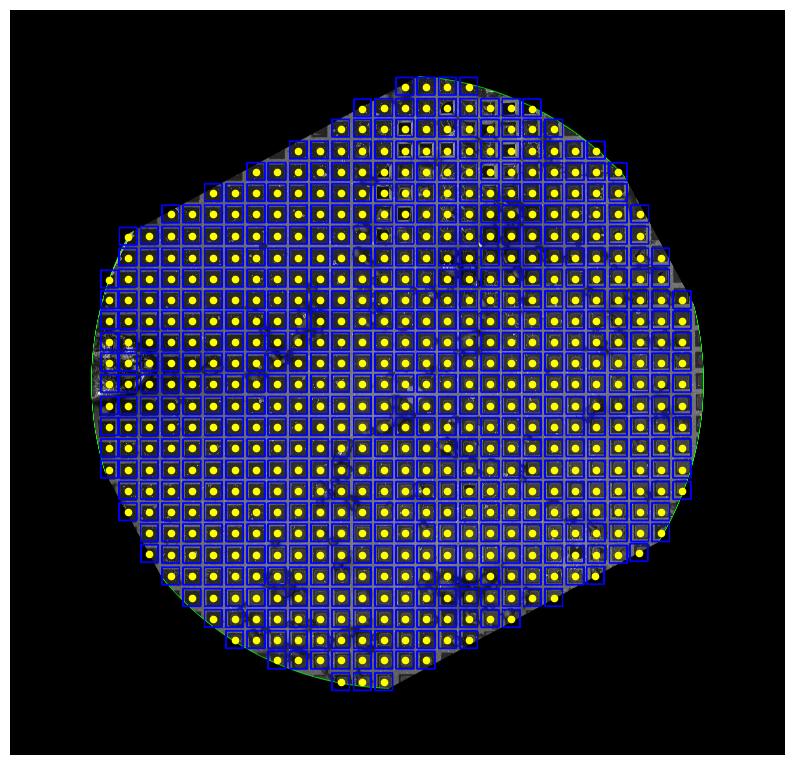

In [ ]:
def detect_squares_around_centers(points, eps=5, min_samples=1):
    clustering = DBSCAN(eps=eps, min_samples=min_samples).fit(points)
    labels = clustering.labels_

    unique_labels = np.unique(labels)
    centers = []
    for label in unique_labels:
        if label == -1:  # Ignore noise points
            continue
        cluster_points = points[labels == label]
        center = np.mean(cluster_points, axis=0)
        centers.append(center)

    return np.array(centers)

# Function to draw squares around the detected centers
def draw_squares(image, centers, square_size, thickness=5):
    for center in centers:
        x, y = center
        top_left = (int(x - square_size // 2), int(y - square_size // 2))
        bottom_right = (int(x + square_size // 2), int(y + square_size // 2))
        cv.rectangle(image, top_left, bottom_right, (255, 0, 0), thickness)  # Draw in red


# Detect square centers using DBSCAN
eps = 20

filtered_grid_points = np.column_stack((filtered_grid_x, filtered_grid_y))
square_centers = detect_squares_around_centers(filtered_grid_points, eps=eps, min_samples=1)

full_filtered_grid_points = np.column_stack((full_filtered_grid_x, full_filtered_grid_y))
full_square_centers = detect_squares_around_centers(full_filtered_grid_points, eps=eps*10, min_samples=1)

# Draw squares around the detected centers
square_size = 50  # Define your square size
draw_squares(rotated_circle_image, square_centers, square_size)
draw_squares(full_rotated_circle_image, full_square_centers, square_size*10, thickness=50)

# Show the image with squares and uniform grid points
plt.figure(figsize=(10, 10))
plt.imshow(cv.cvtColor(rotated_circle_image, cv.COLOR_BGR2RGB))
plt.scatter(square_centers[:, 0], square_centers[:, 1], color='yellow', s=20)  # Detected square centers
plt.axis('off')
plt.show()

# Show the image with squares and uniform grid points
plt.figure(figsize=(10, 10))
plt.imshow(cv.cvtColor(full_rotated_circle_image, cv.COLOR_BGR2RGB))
plt.scatter(full_square_centers[:, 0], full_square_centers[:, 1], color='yellow', s=20)  # Detected square centers
plt.axis('off')
plt.show()

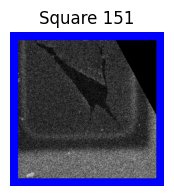

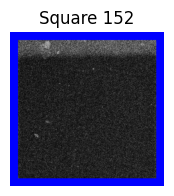

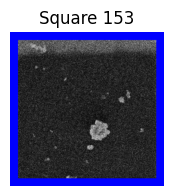

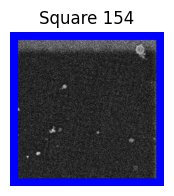

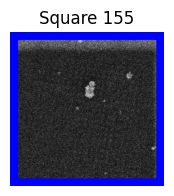

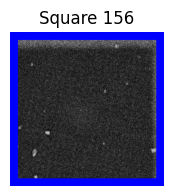

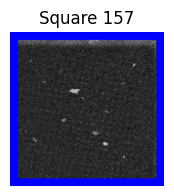

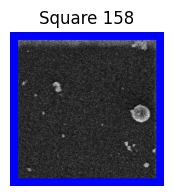

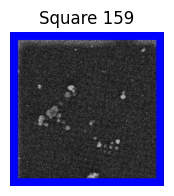

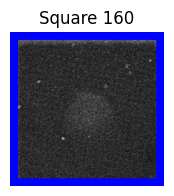

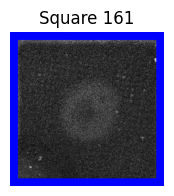

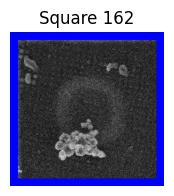

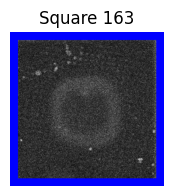

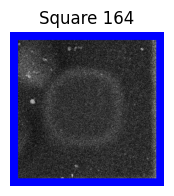

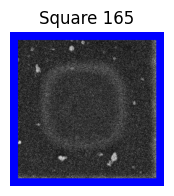

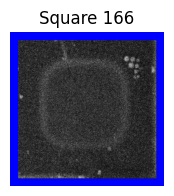

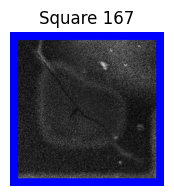

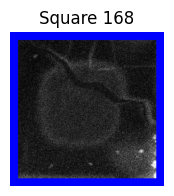

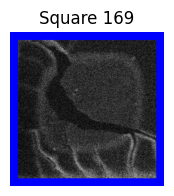

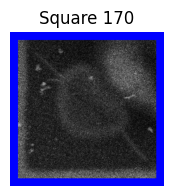

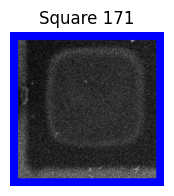

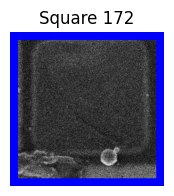

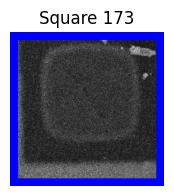

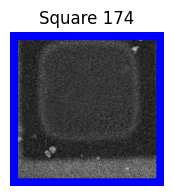

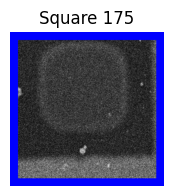

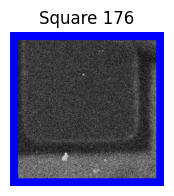

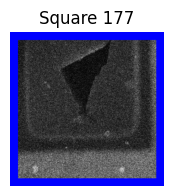

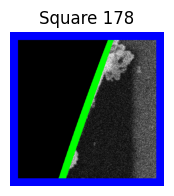

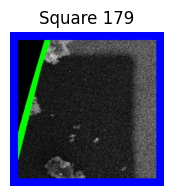

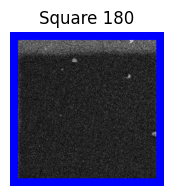

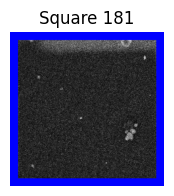

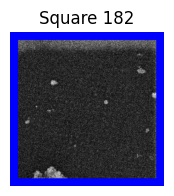

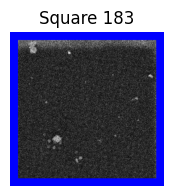

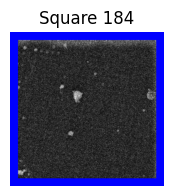

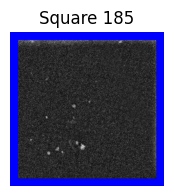

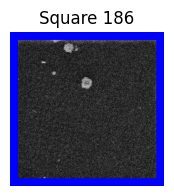

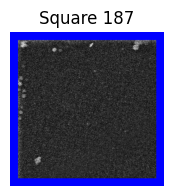

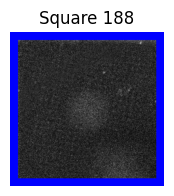

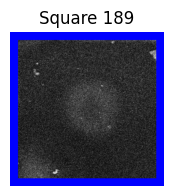

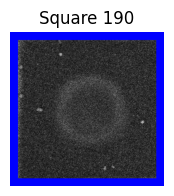

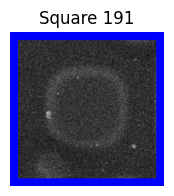

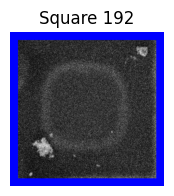

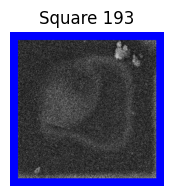

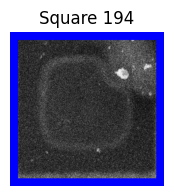

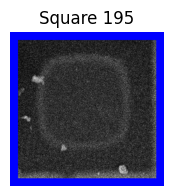

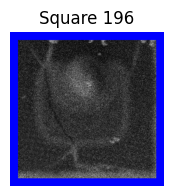

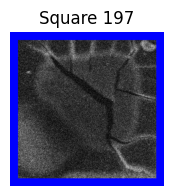

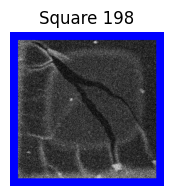

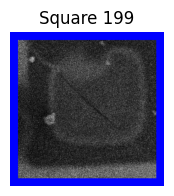

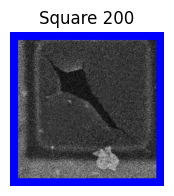

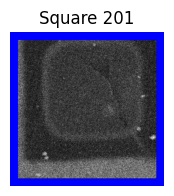

In [ ]:
def crop_squares(image, centers, square_size):
    cropped_squares = []

    half_size = square_size // 2
    for center in centers:
        x, y = center
        # Calculate the top-left and bottom-right coordinates of the square
        top_left = (int(x - half_size), int(y - half_size))
        bottom_right = (int(x + half_size), int(y + half_size))

        # Ensure the coordinates are within image bounds
        top_left = (max(0, top_left[0]), max(0, top_left[1]))
        bottom_right = (min(image.shape[1], bottom_right[0]), min(image.shape[0], bottom_right[1]))

        # Crop the square from the original image
        cropped_square = image[top_left[1]:bottom_right[1], top_left[0]:bottom_right[0]]
        cropped_squares.append(cropped_square)

    return cropped_squares

# Example usage
cropped_squares = crop_squares(full_rotated_circle_image, full_square_centers, square_size*10)

# Optionally display the cropped squares
for i, square in enumerate(cropped_squares):
    if (i >= 150) and (i <= 200):
      plt.figure(figsize=(2, 2))
      plt.imshow(cv.cvtColor(square, cv.COLOR_BGR2RGB))
      plt.axis('off')
      plt.title(f'Square {i+1}')
      plt.show()

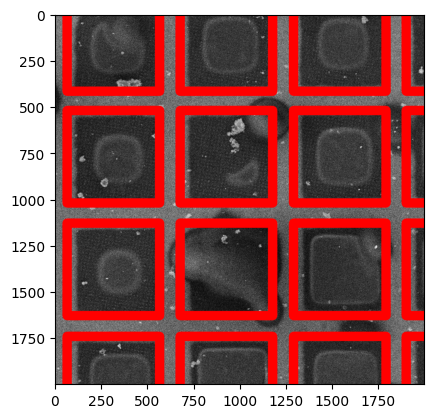

In [ ]:
x_length = full_rotated_circle_image.shape[0]
y_length = full_rotated_circle_image.shape[1]
region = 1500
plt.imshow(full_rotated_circle_image[x_length//2+region-1000:x_length//2+region+1000, y_length//2+region-1000:y_length//2+region+1000, :])
plt.show()